In [1]:
folder_path = 'C:\Applications\Projets\diffusion-model-example'
image_path = f"{folder_path}/dataset/sprites_1788_16x16.npy"
label_path = f"{folder_path}/dataset/sprite_labels_nc_1788_16x16.npy"
save_dir = f'{folder_path}/models/'
# trained_model_path = f'{save_dir}model_31.pth'
trained_model_path = f'{save_dir}context_model_trained.pth'
context_enable = True
ddim_enable = True

import sys
sys.path.append(folder_path)
from utils import diffusion_utils
from utils import data_utils
from utils import context_unet

In [2]:
# from typing import Dict, Tuple
from tqdm import tqdm
import torch
# import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
# from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
import os

# Setting Things Up

In [3]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate=1e-3

In [4]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

In [5]:
# construct model
nn_model = context_unet.ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# Training

In [6]:
# load dataset and construct optimizer
dataset = data_utils.CustomDataset(image_path, label_path, data_utils.transform, null_context=context_enable)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [7]:
# helper function: perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [8]:
# # training with context code
# # set into train mode
# nn_model.train()

# for ep in range(n_epoch):
#     print(f'epoch {ep}')

#     # linearly decay learning rate
#     optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

#     pbar = tqdm(dataloader, mininterval=2 )
#     for x, c in pbar:   # x: images  c: context
#         optim.zero_grad()
#         x = x.to(device)
#         if context_enable:
#           c = c.to(x)
#           # randomly mask out c
#           context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
#           c = c * context_mask.unsqueeze(-1)

#         # perturb data
#         noise = torch.randn_like(x)
#         t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
#         x_pert = perturb_input(x, t, noise)

#         # use network to recover noise
#         if context_enable:
#           pred_noise = nn_model(x_pert, t / timesteps, c=c)
#         else:
#           pred_noise = nn_model(x_pert, t / timesteps)

#         # loss is mean squared error between the predicted and true noise
#         loss = F.mse_loss(pred_noise, noise)
#         loss.backward()

#         optim.step()

#     # save model periodically
#     if ep%4==0 or ep == int(n_epoch-1):
#         if not os.path.exists(save_dir):
#             os.mkdir(save_dir)
#         torch.save(nn_model.state_dict(), save_dir + f"context_model_{ep}.pth")
#         print('saved model at ' + save_dir + f"context_model_{ep}.pth")

In [9]:
# load in pretrain model weights and set to eval mode
nn_model.load_state_dict(torch.load(trained_model_path, map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


# Sampling

In [10]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_ddpm(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [11]:
# define sampling function for DDIM
# removes the noise using ddim
def denoise_ddim(x, t, t_prev, pred_noise):
    ab = ab_t[t]
    ab_prev = ab_t[t_prev]

    x0_pred = ab_prev.sqrt() / ab.sqrt() * (x - (1 - ab).sqrt() * pred_noise)
    dir_xt = (1 - ab_prev).sqrt() * pred_noise

    return x0_pred + dir_xt

In [12]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, save_rate=20, context=None):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = denoise_ddpm(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [13]:
# sample quickly using DDIM
@torch.no_grad()
def sample_ddim(n_sample, n=20, context=None):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    step_size = timesteps // n
    for i in range(timesteps, 0, -step_size):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t)
        samples = denoise_ddim(samples, i, i - step_size, eps)
        intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [14]:
# visualize samples with randomly selected context
plt.clf()

ctx = None
if context_enable:
  ctx = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()

if ddim_enable:
  samples, intermediate = sample_ddim(32, context=ctx)
else:
  samples, intermediate = sample_ddpm(32, context=ctx)

animation_ddpm = diffusion_utils.plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [15]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

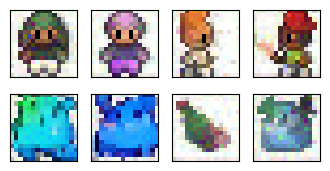

In [16]:
# user defined context
if context_enable:
  ctx = torch.tensor([
      # hero, non-hero, food, spell, side-facing
      [1,0,0,0,0],
      [1,0,0,0,0],
      [0,0,0,0,1],
      [0,0,0,0,1],
      [0,1,0,0,0],
      [0,1,0,0,0],
      [0,0,1,0,0],
      [0,0,1,0,0],
  ]).float().to(device)
  if ddim_enable:
    samples, _ = sample_ddim(ctx.shape[0], context=ctx)
  else:
    samples, _ = sample_ddpm(ctx.shape[0], context=ctx)
  show_images(samples)

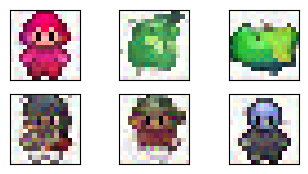

In [17]:
# mix of defined context
if context_enable:
  ctx = torch.tensor([
      # hero, non-hero, food, spell, side-facing
      [1,0,0,0,0],      #human
      [1,0,0.6,0,0],
      [0,0,0.6,0.4,0],
      [1,0,0,0,1],
      [1,1,0,0,0],
      [1,0,0,1,0]
  ]).float().to(device)
  if ddim_enable:
    samples, _ = sample_ddim(ctx.shape[0], context=ctx)
  else:
    samples, _ = sample_ddpm(ctx.shape[0], context=ctx)
  show_images(samples)

In [18]:
%timeit -r 1 sample_ddim(32, n=25)
%timeit -r 1 sample_ddpm(32, )

1.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
28.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
